In [1]:
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
import decimal
import copy
from IPython.display import clear_output
solvers.options['show_progress'] = False

In [63]:
class Agent:
    def __init__(self, agent_id, i_state, g_state, vg, wg, p_horizon, u_horizon):
        # agent state
        self.agent_id = agent_id # id of the agent
        self.agent_radius = 2
        self.obst_radius = 2
        self.i_state = np.array(i_state) # start state
        self.g_state = np.array(g_state) # goal state
        self.c_state = i_state # current state
        self.obstacles = []
        self.n_obst = 0
        self.avoid_obs = False
        # horizons
        self.p_horizon = p_horizon # planning horizon
        self.u_horizon = u_horizon # update horizon
        # initial guesses
        self.vg = matrix(vg)  # initial velocity
        self.wg = matrix(wg) # initial angular velocity
        # last known values
        self.vl = 0 # last known velocity of the agent
        self.wl = 0 # last known angular velocity of the agent
        # current values
        self.v = self.vl # current velocity
        self.w = self.wl # current angular velocity
        # dt
        self.dt = 0.1
        # lists to store vel and angular vel for debugging
        self.x_traj = []
        self.y_traj = []
        self.v_list = [self.v]
        self.w_list = [self.w]
        self.time_list = [] 
        self.avg_time = 0
        
    def get_P_q_x(self):
        
        P_x_ = np.ones((1,2*self.p_horizon))
        
        d_th = np.ones((1,self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg[i]
            d_th[0,i] = s
        
        th_ = np.ones((1,self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[0,i] = th_0 + d_th[0,i]*self.dt
        
        d_x = np.ones((1,self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_x[0,i] = np.cos(th_[0,i])*self.dt
        
        d_w = np.ones((1,self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
            d_w[0,i] = -self.vg[i]*np.sin(th_[0,i])*self.dt**2
            
        s_dw = np.ones((1,self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[0,i] = np.sum(d_w[0,i:self.p_horizon])
        
        P_x_[0,0:self.p_horizon] = d_x
        P_x_[0,self.p_horizon:] = s_dw
        
        P_x = P_x_.T@P_x_
        
        ### Solving for q_x
        q_x = np.ones((2*self.p_horizon))
        x_0 = self.c_state[0]
        v_sum = 0
        w_sum = 0
        for i in range(self.p_horizon):
#             v_sum = v_sum + self.vg[i]*d_x[0,i]
            w_sum = w_sum + self.wg[i]*s_dw[0,i]
            
        z = x_0 - w_sum - self.g_state[0]
        q_x[0:self.p_horizon] = 2*z*d_x
        q_x[self.p_horizon:] = 2*z*s_dw 
        return P_x, q_x
    
    def get_P_q_y(self):
        
        P_y_ = np.ones((1,2*self.p_horizon))
        
        d_th = np.ones((1,self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg[i]
            d_th[0,i] = s
        
        th_ = np.ones((1,self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[0,i] = th_0 + d_th[0,i]*self.dt
        
        d_y = np.ones((1,self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_y[0,i] = np.sin(th_[0,i])*self.dt
        
        d_w = np.ones((1,self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
             d_w[0,i] = self.vg[i]*np.cos(th_[0,i])*self.dt**2
            
        s_dw = np.ones((1,self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[0,i] = np.sum(d_w[0,i:self.p_horizon])
            
        
        P_y_[0,0:self.p_horizon] = d_y
        P_y_[0,self.p_horizon:] = s_dw
        
        P_y = P_y_.T@P_y_
        
        ### Solving for q_y
        q_y = np.ones((2*self.p_horizon))
        y_0 = self.c_state[1]
        w_sum = 0
        for i in range(self.p_horizon):
            w_sum = w_sum + self.wg[i]*s_dw[0,i]
            
        z = y_0 - w_sum - self.g_state[1]
        q_y[0:self.p_horizon] = 2*z*d_y
        q_y[self.p_horizon:] = 2*z*s_dw 
        
        return P_y, q_y
        
    def get_P_q_theta(self):
        P_theta = np.zeros((2*self.p_horizon,2*self.p_horizon))
        P_theta[self.p_horizon:,self.p_horizon:]=self.dt**2*np.ones((self.p_horizon,self.p_horizon))
        
        q_theta = np.zeros((2*self.p_horizon))
        theta_0 = self.c_state[2]
        theta_g = self.g_state[2]
        q_theta[self.p_horizon:]=2*(theta_0 - theta_g)*self.dt * np.ones((self.p_horizon))
    
        return P_theta, q_theta
    
    def get_diff_vel_mat(self):
        P_diff = np.zeros((self.p_horizon,self.p_horizon))
        for i in range(p_horizon-1):
            for j in range(i,i+2):
                P_diff[i,j] = 1
        P_diff[-1,-1] = 1
        P_diff = P_diff + P_diff.T - np.eye(self.p_horizon)
        P_diff = np.concatenate( (P_diff, P_diff), axis = 1 )
        P_diff = np.concatenate( (P_diff, P_diff), axis = 0 )
        
        q_diff = np.zeros((2*self.p_horizon))
        return P_diff, q_diff
    
    def get_continuity_mat(self):
        P_cont = np.zeros((self.p_horizon,self.p_horizon))
        P_cont[0,0] = 1
        P_cont = np.concatenate( (P_cont, P_cont), axis = 1 )
        P_cont = np.concatenate( (P_cont, P_cont), axis = 0 )
        
        q_cont = np.zeros((2*self.p_horizon ))
        q_cont[0] = -2*self.vl
        q_cont[self.p_horizon] = -2*self.wl
        
        return P_cont, q_cont
    
    def obst_constraint(self,ox, oy, i):
        
        left_row = np.zeros((1,2*self.p_horizon))
        right_row = np.zeros((1,1))
        wg = np.array(self.wg).reshape((1,-1))
        vg = np.array(self.vg).reshape((1,-1))
        ox = ox
        oy = oy

        ## w1g, w1g+w2g, w1g+w2g+w3g
        w_sum = np.cumsum(wg[0,:i])
        theta = self.c_state[2]+w_sum*self.dt
                
        ## constant part
        s_r = (self.agent_radius + self.obst_radius)**2 + 1
        
        ## for x part
        
        kx = self.c_state[0] - ox
        cos_vec = vg[0,:i]*np.cos(theta)*self.dt
        kx = kx + np.sum(cos_vec)
        d_vx = 2*kx*np.cos(theta)*self.dt
        
        vg_theta = -vg[0,:i]*np.sin(theta)*self.dt**2
        vg_sum = np.cumsum(vg_theta[::-1]) 
        vg_sum = vg_sum[::-1]
        d_wx = 2*kx*(vg_sum)
        
        const_d_vx = -vg[0,:i]*d_vx
        const_d_wx = -wg[0,:i]*d_wx
        const_x = kx**2 + np.sum(const_d_vx) + np.sum(const_d_wx)
        left_row[0,:i] = d_vx
        left_row[0,self.p_horizon:self.p_horizon+i] = d_wx
        right_row[0,0] = s_r - const_x 
        
        ## for y part
        ky = self.c_state[1] - oy
        sin_vec = vg[0,:i]*np.sin(theta)*self.dt
        ky = ky + np.sum(sin_vec)
        d_vy = 2*ky*np.sin(theta)*self.dt
        
        vg_theta = vg[0,:i]*np.cos(theta)*self.dt**2
        vg_sum = np.cumsum(vg_theta[::-1]) 
        vg_sum = vg_sum[::-1]
        d_wy = 2*ky*vg_sum
        
        const_d_vy = -vg[0,:i]*d_vy
        const_d_wy = -wg[0,:i]*d_wy
        const_y = ky**2 + np.sum(const_d_vy) + np.sum(const_d_wy)
        
        left_row[0,:i] = left_row[0,:i] + d_vy
        left_row[0,self.p_horizon:self.p_horizon+i] = left_row[0,self.p_horizon:self.p_horizon+i] + d_wy
        right_row[0,0] = right_row[0,0] - const_y
        return (-left_row, -right_row)
    
    def pred_controls(self):
        # define the cost function here and optimize the controls to minimize it

        w1 = 1

        v_cost = 99999
        w_cost = 99999
        threshold = 1
#         count = 0
        strt_time = time.time()
        while((v_cost > threshold) or (w_cost > threshold)):
            P_x, q_x = self.get_P_q_x()
            P_y, q_y = self.get_P_q_y()
            P_theta, q_theta = self.get_P_q_theta()

            
            P_cost_1 = ( P_x + P_y + P_theta ) # P matrix for goal reaching cost
            q_cost_1 = ( q_x + q_y + q_theta ) # q vector for goal reaching cost

            
            P = 2*matrix( P_cost_1 , tc='d')
            q = matrix( q_cost_1 , tc='d')
            
            ### Constraints
            
            ## Bound constraints
            
            v_bound = 5
            w_bound = 0.1
            amin = -2 # min acceleration
            amax = 1 # max acceleration
            alphamax = 0.1 # max angular acceleration
            alphamin = -0.1 # min angular acceleration
            
            v_ub = 30*np.ones((self.p_horizon,1))
            v_lb = 0*np.ones((self.p_horizon,1))
            w_ub = 0.5*np.ones((self.p_horizon,1))
            w_lb = -0.5*np.ones((self.p_horizon,1))
            a_ubound = amax * self.dt * np.ones((self.p_horizon-1,1))
            a_lbound = - amin * self.dt * np.ones((self.p_horizon-1,1))
            alpha_ubound = alphamax * self.dt * np.ones((self.p_horizon-1,1))
            alpha_lbound = - alphamin * self.dt * np.ones((self.p_horizon-1,1))

            h_mat = np.concatenate( \
                                      (v_ub, w_ub, -v_lb, -w_lb, self.vg+v_bound, self.wg+w_bound, -(self.vg-v_bound), -(self.wg-w_bound), \
                                       a_ubound, a_lbound, alpha_ubound, alpha_lbound ), \
                                      axis=0) 
            
            av_max = np.concatenate( (np.diff(np.eye(self.p_horizon),axis = 0), np.zeros( (self.p_horizon-1,self.p_horizon) ) ), axis=1 )
            av_min = -av_max
            aw_max = np.concatenate( ( np.zeros( (self.p_horizon-1,self.p_horizon) ), np.diff( np.eye(self.p_horizon) ,axis = 0 ) ), axis=1 )
            aw_min = -aw_max
            
            g_mat = np.concatenate( \
                                      ( np.eye(2*self.p_horizon),-np.eye(2*self.p_horizon), np.eye(2*self.p_horizon), -np.eye(2*self.p_horizon), \
                                      av_max, av_min, aw_max, aw_min ), \
                                      axis=0)
            if(self.avoid_obs):
                self.n_obst = len(self.obstacles)
                for i_obs in range(self.n_obst):
                    dist = np.sqrt((self.c_state[0] - self.obstacles[i_obs].c_state[0])**2 + (self.c_state[1] - self.obstacles[i_obs].c_state[1])**2)
#                     print(dist)
#                     time.sleep(1)
                    if(dist<=50):
#                         print("check")
#                         time.sleep(10)
                        o_state = copy.deepcopy(self.obstacles[i_obs].c_state)
                        o_wg = copy.deepcopy(np.array(self.obstacles[i_obs].wg).reshape((1,-1)))
                        o_vg = copy.deepcopy(np.array(self.obstacles[i_obs].vg).reshape((1,-1)))
                        o_dt = copy.deepcopy(self.obstacles[i_obs].dt)
                        for zter in range(self.p_horizon):
                            o_state[2] = o_state[2] + o_wg[0,zter]*o_dt
                            o_state[0] = o_state[0] + o_vg[0,zter]*np.cos(o_state[2])*o_dt
                            o_state[1] = o_state[1] + o_vg[0,zter]*np.sin(o_state[2])*o_dt
                            ox = o_state[0]
                            oy = o_state[1]
                            left, right = self.obst_constraint(ox, oy, zter+1)
                            g_mat = np.concatenate((g_mat, left), axis=0)
                            h_mat = np.concatenate((h_mat, right), axis=0)
                            
            h = matrix(h_mat,tc='d')
            G = matrix(g_mat,tc='d')

            ## Continuity constraints
            
            A = np.zeros((2,2*self.p_horizon))
            A[0,0] = 1
            A[1,self.p_horizon] = 1
            A = matrix(A,tc='d')
            b = matrix([self.vl, self.wl],(2,1),tc='d')
            
            sol=solvers.qp(P, q, G, h, A, b)
            v_cost = np.linalg.norm(self.vg - sol['x'][0:self.p_horizon])
            w_cost = np.linalg.norm(self.wg - sol['x'][self.p_horizon:])
            self.vg = sol['x'][0:self.p_horizon]
            self.wg = sol['x'][self.p_horizon:]   
        end_time = time.time()
        self.time_list.append(end_time-strt_time)
        return sol
       
    def non_hol_update(self):
        self.c_state[2] = self.c_state[2] + self.w*self.dt
        self.c_state[0] = self.c_state[0] + self.v*np.cos(self.c_state[2])*self.dt
        self.c_state[1] = self.c_state[1] + self.v*np.sin(self.c_state[2])*self.dt
        
    def draw_circle(self, x, y):
        th = np.arange(0,2*np.pi,0.01)
        xunit = self.agent_radius * np.cos(th) + x
        yunit = self.agent_radius * np.sin(th) + y
        return xunit, yunit  
    
    def get_traj(self,k):
        state = copy.deepcopy(self.c_state)
        for i in range(k,self.p_horizon):
            state[2] = state[2] + self.wg[i]*self.dt
            state[0] = state[0] + self.vg[i]*np.cos(state[2])*self.dt
            state[1] = state[1] + self.vg[i]*np.sin(state[2])*self.dt
            self.x_traj.append(state[0])
            self.y_traj.append(state[1])
        

In [64]:
def get_dist(a_state, o_state):
    d = np.sqrt((o_state[0] - a_state[0])**2 + (o_state[1] - a_state[1])**2)
    return d
    

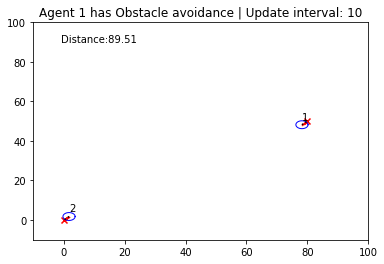

average time taken for each optimization step: 0.05570819798637839 secs
average time taken for each optimization step: 0.05045360677382525 secs
Minimum distance between the agents:  6.989479171840772


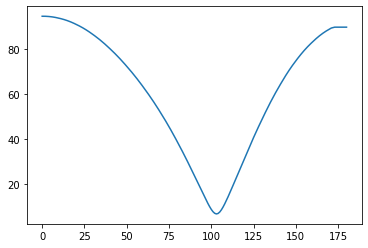

In [46]:
p_horizon = 50
u_horizon = 10

### initialize vg and wg
vg = 0*np.ones((p_horizon,1))
wg = 0*np.ones((p_horizon,1))
# vg = np.random.random((p_horizon,1))
# wg = np.random.random((p_horizon,1))

agent1 = Agent(1, [0,0,np.deg2rad(45)],[80,50,np.deg2rad(45)], vg, wg, p_horizon, u_horizon)
agent2 = Agent(2, [80,50,np.deg2rad(225)],[0,0,np.deg2rad(225)], vg, wg, p_horizon, u_horizon)
agent1.obstacles = [agent2]
agent2.obstacles = [agent1] 
agent1.avoid_obs = True
agent2.avoid_obs = True
th = 2.5
timeout = 200
rec_video = False
if(rec_video):
    plt_sv_dir = "../2_pipeline/tmp/"
    p = 0
dist1 = [] 
dist1.append(get_dist(agent1.c_state, agent2.c_state))
while( ( (np.linalg.norm(agent1.c_state-agent1.g_state)>th) or (np.linalg.norm(agent2.c_state-agent2.g_state)>th) ) and timeout>0):
    agent1.pred_controls()
    agent2.pred_controls()
    for i in range(u_horizon):
        if(np.linalg.norm(agent1.c_state-agent1.g_state)>th):
            agent1.v = agent1.vg[i]
            agent1.w = agent1.wg[i]
            agent1.v_list.append(agent1.v)
            agent1.x_traj = []
            agent1.y_traj = []
            agent1.get_traj(i)
            agent1.non_hol_update()
        if(np.linalg.norm(agent2.c_state-agent2.g_state)>th):
            agent2.v = agent2.vg[i]
            agent2.w = agent2.wg[i]
            agent2.v_list.append(agent2.v)
            agent2.x_traj = []
            agent2.y_traj = []
            agent2.get_traj(i)
            agent2.non_hol_update()
        dist1.append(get_dist(agent1.c_state, agent2.c_state))
        if(not rec_video):
            clear_output(wait=True)
        xa,ya = agent1.draw_circle(agent1.c_state[0], agent1.c_state[1])
        xb,yb = agent2.draw_circle(agent2.c_state[0], agent2.c_state[1])

        plt.plot(xa,ya,'b',linewidth=1)
        plt.annotate('1', xy=(agent1.c_state[0], agent1.c_state[1]+2.5))
        plt.plot(xb,yb,'b',linewidth=1)
        plt.annotate('2', xy=(agent2.c_state[0], agent2.c_state[1]+2.5))
        
        plt.annotate('Distance:'+str(round(dist1[-1],2)), xy=(-1,90))
        
        plt.scatter(agent1.g_state[0],agent1.g_state[1],marker='x', color='r')
        plt.scatter(agent1.x_traj, agent1.y_traj,marker='.', color='r', s=1)
        plt.plot([agent1.c_state[0],agent1.g_state[0]],[agent1.c_state[1],agent1.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent2.g_state[0],agent2.g_state[1],marker='x', color='r')
        plt.scatter(agent2.x_traj, agent2.y_traj,marker='.', color='r', s=1)
        plt.plot([agent2.c_state[0],agent2.g_state[0]],[agent2.c_state[1],agent2.g_state[1]], linestyle='dotted', c='k')
        
        plt.xlim([-10,100])
        plt.ylim([-10,100])
        plt.title("Agent 1 has Obstacle avoidance | Update interval: "+str(u_horizon))  
        
        if(rec_video):
            plt.savefig(plt_sv_dir+str(p)+".png",dpi=500, bbox_inches='tight')
            p = p+1
            plt.clf()
        else:
            plt.show()
        timeout = timeout - agent1.dt
        
    agent1.vl = agent1.v
    agent1.wl = agent1.w
    agent2.vl = agent2.v
    agent2.wl = agent2.w
    
agent1.avg_time = sum(agent1.time_list[1:])/len(agent1.time_list[1:])
print("average time taken for each optimization step: {} secs".format(agent1.avg_time))
agent2.avg_time = sum(agent2.time_list[1:])/len(agent2.time_list[1:])
print("average time taken for each optimization step: {} secs".format(agent2.avg_time))
print("Minimum distance between the agents: ",min(np.array(dist1)))
plt.plot(np.array(dist1))
plt.show()
if(timeout <= 0):
    print("Stopped because of timeout.")

## 3 agents

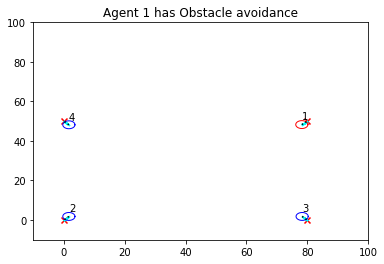

average time taken by agent1 for each optimization step: 0.05583801865577698 secs
average time taken by agent2 for each optimization step: 0.01736890772978465 secs
average time taken by agent3 for each optimization step: 0.016489937901496887 secs
average time taken by agent4 for each optimization step: 0.01651140550772349 secs
Minimum distance between the agent1 and agent2:  11.796233910494445
Minimum distance between the agent1 and agent3:  4.123108362351674
Minimum distance between the agent1 and agent4:  6.928462598164567


In [65]:
p_horizon = 50
u_horizon = 5

### initialize vg and wg
vg = 0*np.ones((p_horizon,1))
wg = 0*np.ones((p_horizon,1))
# vg = np.random.random((p_horizon,1))
# wg = np.random.random((p_horizon,1))

agent1 = Agent(1, [0,0,np.deg2rad(45)],[80,50,np.deg2rad(45)], vg, wg, p_horizon, u_horizon)
agent2 = Agent(2, [80,50,np.deg2rad(225)],[0,0,np.deg2rad(225)], vg, wg, p_horizon, u_horizon)
agent3 = Agent(3, [0,50,np.deg2rad(-45)],[80,0,np.deg2rad(-45)], vg, wg, p_horizon, u_horizon)
agent4 = Agent(4, [80,0,np.deg2rad(135)],[0,50,np.deg2rad(135)], vg, wg, p_horizon, u_horizon)

agent1.obstacles = [agent2, agent3, agent4]
agent2.obstacles = [agent1, agent3, agent4]
agent3.obstacles = [agent1, agent2, agent4]
agent1.avoid_obs = True
agent2.avoid_obs = False
agent3.avoid_obs = False
agent4.avoid_obs = False

th = 2.5
timeout = 200
dist2 = [] # dist between 1 and 2 
dist3 = [] # dist between 1 and 3
dist4 = [] # dist between 1 and 4

dist2.append(get_dist(agent1.c_state, agent2.c_state))
dist3.append(get_dist(agent1.c_state, agent3.c_state))
dist4.append(get_dist(agent1.c_state, agent4.c_state))

rec_video = False
if(rec_video):
    plt_sv_dir = "../2_pipeline/tmp/"
    p = 0

while( ( (np.linalg.norm(agent1.c_state-agent1.g_state)>th) or \
        (np.linalg.norm(agent2.c_state-agent2.g_state)>th) or \
        (np.linalg.norm(agent3.c_state-agent3.g_state)>th) or \
        (np.linalg.norm(agent4.c_state-agent4.g_state)>th)) and timeout>0):
    
    agent2.pred_controls()
    agent3.pred_controls()
    agent4.pred_controls()
    agent1.pred_controls()
    
    for i in range(u_horizon):
        if(np.linalg.norm(agent1.c_state-agent1.g_state)>th):
            agent1.v = agent1.vg[i]
            agent1.w = agent1.wg[i]
            agent1.v_list.append(agent1.v)
            agent1.x_traj = []
            agent1.y_traj = []
            agent1.get_traj(i)
            agent1.non_hol_update()
        if(np.linalg.norm(agent2.c_state-agent2.g_state)>th):
            agent2.v = agent2.vg[i]
            agent2.w = agent2.wg[i]
            agent2.v_list.append(agent2.v)
            agent2.x_traj = []
            agent2.y_traj = []
            agent2.get_traj(i)
            agent2.non_hol_update()
        if(np.linalg.norm(agent3.c_state-agent3.g_state)>th):
            agent3.v = agent3.vg[i]
            agent3.w = agent3.wg[i]
            agent3.v_list.append(agent3.v)
            agent3.x_traj = []
            agent3.y_traj = []
            agent3.get_traj(i)
            agent3.non_hol_update()
        if(np.linalg.norm(agent4.c_state-agent4.g_state)>th):
            agent4.v = agent4.vg[i]
            agent4.w = agent4.wg[i]
            agent4.v_list.append(agent4.v)
            agent4.x_traj = []
            agent4.y_traj = []
            agent4.get_traj(i)
            agent4.non_hol_update()
        dist2.append(get_dist(agent1.c_state, agent2.c_state))
        dist3.append(get_dist(agent1.c_state, agent3.c_state))
        dist4.append(get_dist(agent1.c_state, agent4.c_state))
        
        if(not rec_video):
            clear_output(wait=True)
            
        xa,ya = agent1.draw_circle(agent1.c_state[0], agent1.c_state[1])
        xb,yb = agent2.draw_circle(agent2.c_state[0], agent2.c_state[1])
        xc,yc = agent3.draw_circle(agent3.c_state[0], agent3.c_state[1])
        xd,yd = agent4.draw_circle(agent4.c_state[0], agent4.c_state[1])

        plt.plot(xa,ya,'red',linewidth=1)
        plt.annotate('1', xy=(agent1.c_state[0], agent1.c_state[1]+2.5))
        plt.plot(xb,yb,'b',linewidth=1)
        plt.annotate('2', xy=(agent2.c_state[0], agent2.c_state[1]+2.5))
        plt.plot(xc,yc,'b',linewidth=1)
        plt.annotate('3', xy=(agent3.c_state[0], agent3.c_state[1]+2.5))
        plt.plot(xd,yd,'b',linewidth=1)
        plt.annotate('4', xy=(agent4.c_state[0], agent4.c_state[1]+2.5))
                
        plt.scatter(agent1.g_state[0],agent1.g_state[1],marker='x', color='r')
        plt.scatter(agent1.x_traj, agent1.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent1.c_state[0],agent1.g_state[0]],[agent1.c_state[1],agent1.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent2.g_state[0],agent2.g_state[1],marker='x', color='r')
        plt.scatter(agent2.x_traj, agent2.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent2.c_state[0],agent2.g_state[0]],[agent2.c_state[1],agent2.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent3.g_state[0],agent3.g_state[1],marker='x', color='r')
        plt.scatter(agent3.x_traj, agent3.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent3.c_state[0],agent3.g_state[0]],[agent3.c_state[1],agent3.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent4.g_state[0],agent4.g_state[1],marker='x', color='r')
        plt.scatter(agent4.x_traj, agent4.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent4.c_state[0],agent4.g_state[0]],[agent4.c_state[1],agent4.g_state[1]], linestyle='dotted', c='k')
        
        plt.xlim([-10,100])
        plt.ylim([-10,100])
        plt.title("Agent 1 has Obstacle avoidance")  
        
        if(rec_video):
            plt.savefig(plt_sv_dir+str(p)+".png",dpi=500, bbox_inches='tight')
            p = p+1
            plt.clf()
        else:
            plt.show()
        timeout = timeout - agent1.dt
        
    agent1.vl = agent1.v
    agent1.wl = agent1.w
    agent2.vl = agent2.v
    agent2.wl = agent2.w
    agent3.vl = agent3.v
    agent3.wl = agent3.w
    agent4.vl = agent4.v
    agent4.wl = agent4.w
    
agent1.avg_time = sum(agent1.time_list[1:])/len(agent1.time_list[1:])
print("average time taken by agent1 for each optimization step: {} secs".format(agent1.avg_time))
agent2.avg_time = sum(agent2.time_list[1:])/len(agent2.time_list[1:])
print("average time taken by agent2 for each optimization step: {} secs".format(agent2.avg_time))
agent3.avg_time = sum(agent3.time_list[1:])/len(agent3.time_list[1:])
print("average time taken by agent3 for each optimization step: {} secs".format(agent3.avg_time))
agent4.avg_time = sum(agent4.time_list[1:])/len(agent4.time_list[1:])
print("average time taken by agent4 for each optimization step: {} secs".format(agent4.avg_time))

print("Minimum distance between the agent1 and agent2: ",min(np.array(dist2)))
print("Minimum distance between the agent1 and agent3: ",min(np.array(dist3)))
print("Minimum distance between the agent1 and agent4: ",min(np.array(dist4)))

if(timeout <= 0):
    print("Stopped because of timeout.")

## 8 agents

In [75]:
p_horizon = 50
u_horizon = 10

### initialize vg and wg
vg = 0*np.ones((p_horizon,1))
wg = 0*np.ones((p_horizon,1))
# vg = np.random.random((p_horizon,1))
# wg = np.random.random((p_horizon,1))

agent1 = Agent(1,[-60,-30,0.78],[80,30,0.78], vg, wg, p_horizon, u_horizon);
agent2 = Agent(2,[-60,40,-0.78],[60,-80,-0.78], vg, wg, p_horizon, u_horizon);
agent3 = Agent(3, [-80,0,0], [80,0,0], vg, wg, p_horizon, u_horizon);
agent4 = Agent(4,[0,-80,1.5],[0,80,1.5], vg, wg, p_horizon, u_horizon);
agent5 = Agent(5,[-30,-60,0.7],[80,70,0.7], vg, wg, p_horizon, u_horizon);
agent6 = Agent(6,[40,-70,2.3],[-40,80,2.3], vg, wg, p_horizon, u_horizon);
agent7 = Agent(7,[50,-60,1.5],[50,70,1.5], vg, wg, p_horizon, u_horizon);
agent8 = Agent(8,[-30,60,-1.5],[-30,-60,-1.5], vg, wg, p_horizon, u_horizon);

agent1.obstacles = [agent2, agent3, agent4, agent5, agent6, agent7, agent8]
# agent2.obstacles = [agent1, agent3, agent4]
# agent3.obstacles = [agent1, agent2, agent4]
agent1.avoid_obs = True
# agent2.avoid_obs = False
# agent3.avoid_obs = False
# agent4.avoid_obs = False

th = 2.5
timeout = 200
dist2 = [] # dist between 1 and 2 
dist3 = [] # dist between 1 and 3
dist4 = [] # dist between 1 and 4
dist5 = [] # dist between 1 and 5
dist6 = [] # dist between 1 and 6
dist7 = [] # dist between 1 and 7
dist8 = [] # dist between 1 and 8

dist2.append(get_dist(agent1.c_state, agent2.c_state))
dist3.append(get_dist(agent1.c_state, agent3.c_state))
dist4.append(get_dist(agent1.c_state, agent4.c_state))
dist5.append(get_dist(agent1.c_state, agent5.c_state))
dist6.append(get_dist(agent1.c_state, agent6.c_state))
dist7.append(get_dist(agent1.c_state, agent7.c_state))
dist8.append(get_dist(agent1.c_state, agent8.c_state))

rec_video = True
if(rec_video):
    plt_sv_dir = "../2_pipeline/tmp/"
    p = 0

while( ( (np.linalg.norm(agent1.c_state-agent1.g_state)>th) or \
        (np.linalg.norm(agent2.c_state-agent2.g_state)>th) or \
        (np.linalg.norm(agent3.c_state-agent3.g_state)>th) or \
        (np.linalg.norm(agent4.c_state-agent4.g_state)>th) or \
        (np.linalg.norm(agent5.c_state-agent5.g_state)>th) or \
        (np.linalg.norm(agent6.c_state-agent6.g_state)>th) or \
        (np.linalg.norm(agent7.c_state-agent7.g_state)>th) or \
        (np.linalg.norm(agent8.c_state-agent8.g_state)>th) ) \
       and timeout>0):
    
    agent2.pred_controls()
    agent3.pred_controls()
    agent4.pred_controls()
    agent5.pred_controls()
    agent6.pred_controls()
    agent7.pred_controls()
    agent8.pred_controls()
    agent1.pred_controls()
    
    for i in range(u_horizon):
        if(np.linalg.norm(agent1.c_state-agent1.g_state)>th):
            agent1.v = agent1.vg[i]
            agent1.w = agent1.wg[i]
            agent1.v_list.append(agent1.v)
            agent1.x_traj = []
            agent1.y_traj = []
            agent1.get_traj(i)
            agent1.non_hol_update()
        if(np.linalg.norm(agent2.c_state-agent2.g_state)>th):
            agent2.v = agent2.vg[i]
            agent2.w = agent2.wg[i]
            agent2.v_list.append(agent2.v)
            agent2.x_traj = []
            agent2.y_traj = []
            agent2.get_traj(i)
            agent2.non_hol_update()
        if(np.linalg.norm(agent3.c_state-agent3.g_state)>th):
            agent3.v = agent3.vg[i]
            agent3.w = agent3.wg[i]
            agent3.v_list.append(agent3.v)
            agent3.x_traj = []
            agent3.y_traj = []
            agent3.get_traj(i)
            agent3.non_hol_update()
        if(np.linalg.norm(agent4.c_state-agent4.g_state)>th):
            agent4.v = agent4.vg[i]
            agent4.w = agent4.wg[i]
            agent4.v_list.append(agent4.v)
            agent4.x_traj = []
            agent4.y_traj = []
            agent4.get_traj(i)
            agent4.non_hol_update()
        if(np.linalg.norm(agent5.c_state-agent5.g_state)>th):
            agent5.v = agent5.vg[i]
            agent5.w = agent5.wg[i]
            agent5.v_list.append(agent5.v)
            agent5.x_traj = []
            agent5.y_traj = []
            agent5.get_traj(i)
            agent5.non_hol_update()
        if(np.linalg.norm(agent6.c_state-agent6.g_state)>th):
            agent6.v = agent6.vg[i]
            agent6.w = agent6.wg[i]
            agent6.v_list.append(agent6.v)
            agent6.x_traj = []
            agent6.y_traj = []
            agent6.get_traj(i)
            agent6.non_hol_update()
        if(np.linalg.norm(agent7.c_state-agent7.g_state)>th):
            agent7.v = agent7.vg[i]
            agent7.w = agent7.wg[i]
            agent7.v_list.append(agent7.v)
            agent7.x_traj = []
            agent7.y_traj = []
            agent7.get_traj(i)
            agent7.non_hol_update()
        if(np.linalg.norm(agent8.c_state-agent8.g_state)>th):
            agent8.v = agent8.vg[i]
            agent8.w = agent8.wg[i]
            agent8.v_list.append(agent8.v)
            agent8.x_traj = []
            agent8.y_traj = []
            agent8.get_traj(i)
            agent8.non_hol_update()
        dist2.append(get_dist(agent1.c_state, agent2.c_state))
        dist3.append(get_dist(agent1.c_state, agent3.c_state))
        dist4.append(get_dist(agent1.c_state, agent4.c_state))
        dist5.append(get_dist(agent1.c_state, agent5.c_state))
        dist6.append(get_dist(agent1.c_state, agent6.c_state))
        dist7.append(get_dist(agent1.c_state, agent7.c_state))
        dist8.append(get_dist(agent1.c_state, agent8.c_state))
        
        if(not rec_video):
            clear_output(wait=True)
            
        xa,ya = agent1.draw_circle(agent1.c_state[0], agent1.c_state[1])
        xb,yb = agent2.draw_circle(agent2.c_state[0], agent2.c_state[1])
        xc,yc = agent3.draw_circle(agent3.c_state[0], agent3.c_state[1])
        xd,yd = agent4.draw_circle(agent4.c_state[0], agent4.c_state[1])
        xe,ye = agent5.draw_circle(agent5.c_state[0], agent5.c_state[1])
        xf,yf = agent6.draw_circle(agent6.c_state[0], agent6.c_state[1])
        xg,yg = agent7.draw_circle(agent7.c_state[0], agent7.c_state[1])
        xh,yh = agent8.draw_circle(agent8.c_state[0], agent8.c_state[1])

        plt.plot(xa,ya,'red',linewidth=1)
        plt.annotate('1', xy=(agent1.c_state[0], agent1.c_state[1]+2.5))
        plt.plot(xb,yb,'b',linewidth=1)
        plt.annotate('2', xy=(agent2.c_state[0], agent2.c_state[1]+2.5))
        plt.plot(xc,yc,'b',linewidth=1)
        plt.annotate('3', xy=(agent3.c_state[0], agent3.c_state[1]+2.5))
        plt.plot(xd,yd,'b',linewidth=1)
        plt.annotate('4', xy=(agent4.c_state[0], agent4.c_state[1]+2.5))
        plt.plot(xe,ye,'b',linewidth=1)
        plt.annotate('5', xy=(agent5.c_state[0], agent5.c_state[1]+2.5))
        plt.plot(xf,yf,'b',linewidth=1)
        plt.annotate('6', xy=(agent6.c_state[0], agent6.c_state[1]+2.5))
        plt.plot(xg,yg,'b',linewidth=1)
        plt.annotate('7', xy=(agent7.c_state[0], agent7.c_state[1]+2.5))
        plt.plot(xh,yh,'b',linewidth=1)
        plt.annotate('8', xy=(agent8.c_state[0], agent8.c_state[1]+2.5))
            
        plt.scatter(agent1.g_state[0],agent1.g_state[1],marker='x', color='r')
        plt.scatter(agent1.x_traj, agent1.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent1.c_state[0],agent1.g_state[0]],[agent1.c_state[1],agent1.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent2.g_state[0],agent2.g_state[1],marker='x', color='r')
        plt.scatter(agent2.x_traj, agent2.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent2.c_state[0],agent2.g_state[0]],[agent2.c_state[1],agent2.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent3.g_state[0],agent3.g_state[1],marker='x', color='r')
        plt.scatter(agent3.x_traj, agent3.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent3.c_state[0],agent3.g_state[0]],[agent3.c_state[1],agent3.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent4.g_state[0],agent4.g_state[1],marker='x', color='r')
        plt.scatter(agent4.x_traj, agent4.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent4.c_state[0],agent4.g_state[0]],[agent4.c_state[1],agent4.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent5.g_state[0],agent5.g_state[1],marker='x', color='r')
        plt.scatter(agent5.x_traj, agent5.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent5.c_state[0],agent5.g_state[0]],[agent5.c_state[1],agent5.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent6.g_state[0],agent6.g_state[1],marker='x', color='r')
        plt.scatter(agent6.x_traj, agent6.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent6.c_state[0],agent6.g_state[0]],[agent6.c_state[1],agent6.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent7.g_state[0],agent7.g_state[1],marker='x', color='r')
        plt.scatter(agent7.x_traj, agent7.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent7.c_state[0],agent7.g_state[0]],[agent7.c_state[1],agent7.g_state[1]], linestyle='dotted', c='k')
        
        plt.scatter(agent8.g_state[0],agent8.g_state[1],marker='x', color='r')
        plt.scatter(agent8.x_traj, agent8.y_traj,marker='.', color='cyan', s=1)
        plt.plot([agent8.c_state[0],agent8.g_state[0]],[agent8.c_state[1],agent8.g_state[1]], linestyle='dotted', c='k')
        
        plt.xlim([-100,100])
        plt.ylim([-100,100])
        plt.title("Agent 1 has Obstacle avoidance")  
        
        if(rec_video):
            plt.savefig(plt_sv_dir+str(p)+".png",dpi=500, bbox_inches='tight')
            p = p+1
            plt.clf()
        else:
            plt.show()
        timeout = timeout - agent1.dt
        
    agent1.vl = agent1.v
    agent1.wl = agent1.w
    agent2.vl = agent2.v
    agent2.wl = agent2.w
    agent3.vl = agent3.v
    agent3.wl = agent3.w
    agent4.vl = agent4.v
    agent4.wl = agent4.w
    agent5.vl = agent5.v
    agent5.wl = agent5.w
    agent6.vl = agent6.v
    agent6.wl = agent6.w
    agent7.vl = agent7.v
    agent7.wl = agent7.w
    agent8.vl = agent8.v
    agent8.wl = agent8.w
    
agent1.avg_time = sum(agent1.time_list[1:])/len(agent1.time_list[1:])
print("average time taken by agent1 for each optimization step: {} secs".format(agent1.avg_time))
# agent2.avg_time = sum(agent2.time_list[1:])/len(agent2.time_list[1:])
# print("average time taken by agent2 for each optimization step: {} secs".format(agent2.avg_time))
# agent3.avg_time = sum(agent3.time_list[1:])/len(agent3.time_list[1:])
# print("average time taken by agent3 for each optimization step: {} secs".format(agent3.avg_time))
# agent4.avg_time = sum(agent4.time_list[1:])/len(agent4.time_list[1:])
# print("average time taken by agent4 for each optimization step: {} secs".format(agent4.avg_time))

print("Minimum distance between the agent1 and agent2: ",min(np.array(dist2)))
print("Minimum distance between the agent1 and agent3: ",min(np.array(dist3)))
print("Minimum distance between the agent1 and agent4: ",min(np.array(dist4)))
print("Minimum distance between the agent1 and agent5: ",min(np.array(dist5)))
print("Minimum distance between the agent1 and agent6: ",min(np.array(dist6)))
print("Minimum distance between the agent1 and agent7: ",min(np.array(dist7)))
print("Minimum distance between the agent1 and agent8: ",min(np.array(dist8)))

if(timeout <= 0):
    print("Stopped because of timeout.")

average time taken by agent1 for each optimization step: 0.12392565182277135 secs
Minimum distance between the agent1 and agent2:  17.3438065047653
Minimum distance between the agent1 and agent3:  10.449323075742447
Minimum distance between the agent1 and agent4:  8.376261767008698
Minimum distance between the agent1 and agent5:  7.897992605266698
Minimum distance between the agent1 and agent6:  4.1222458764841585
Minimum distance between the agent1 and agent7:  39.06058482396706
Minimum distance between the agent1 and agent8:  20.89133697057883


<Figure size 432x288 with 0 Axes>